<a href="https://colab.research.google.com/github/fredericoschardong/HR-GLDD-a-globally-distributed-dataset-using-generalized-deep-learning-for-rapid-landslide-mapping/blob/main/Codes/Unet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train U-Net on the HR Global Landslide Detection Dataset

*Authors: Sansar Raj Meena, Lorenzo Nava, Kushanav Bhuyan, and Lucas Soares*

In [1]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.10
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/qubvel/segmentation_models/issues/570#issuecomment-1641512983
# solucão para o segmentation_models desatualizado
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'


from tensorflow.keras import layers
from tensorflow import keras
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import tensorflow.python.keras.utils.generic_utils as generic_utils
#from tensorflow.python.keras.utils import generic_utils
tf.keras.utils.generic_utils = generic_utils

import tensorflow.keras.backend as K

# from losses import dice_loss
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss


# Library with segmentation metrics
import segmentation_models as sm

physical_devices = tf.config.experimental.list_physical_devices('GPU')

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

if tf.test.gpu_device_name():

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.10
Segmentation Models: using `tf.keras` framework.
Please install GPU version of TF


In [3]:
X_train = np.load(f'data/arrays/trainX.npy')
Y_train = np.load(f'data/arrays/trainY.npy')
X_val = np.load(f'data/arrays/valX.npy')
Y_val = np.load(f'data/arrays/valY.npy')
X_test = np.load(f'data/arrays/testX.npy')
Y_test = np.load(f'data/arrays/testY.npy')
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1119, 128, 128, 4)
(1119, 128, 128, 1)
(284, 128, 128, 4)
(284, 128, 128, 1)
(355, 128, 128, 4)
(355, 128, 128, 1)


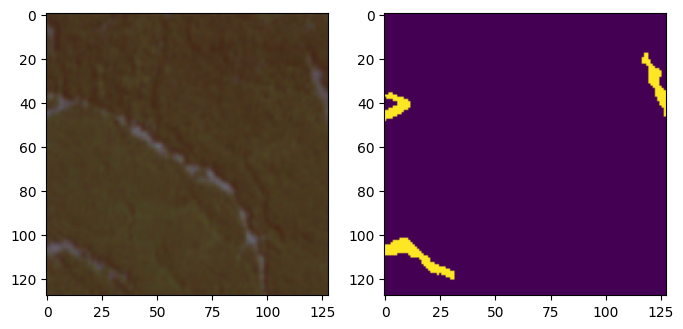

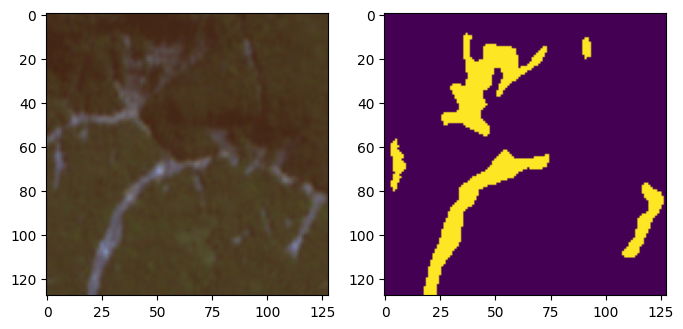

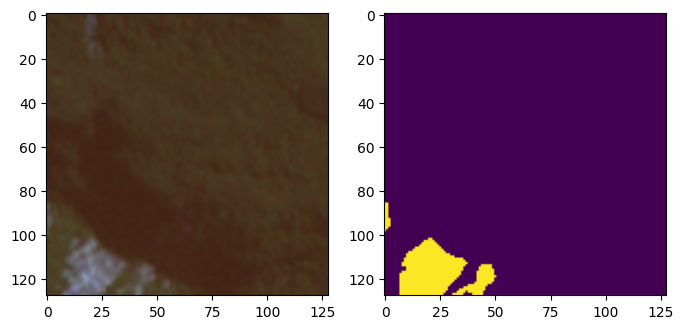

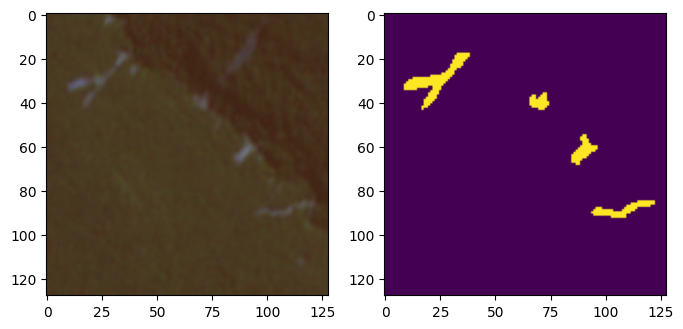

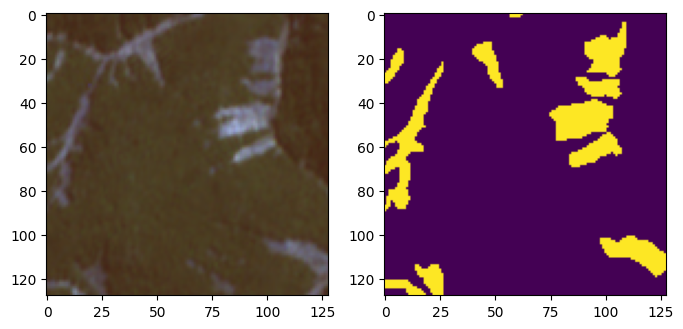

In [4]:
# Visualise some data
for i in range(5):
    f, axarr = plt.subplots(1,2,figsize=(8,8))
    axarr[0].imshow(X_train[i][:,:,:3])
    axarr[1].imshow(np.squeeze(Y_train[i]))

In [5]:
# Define the evaluation metrics - Precision, Recall, FScore, IoU
metrics = [sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5),sm.metrics.FScore(threshold=0.5,beta=1),sm.metrics.IOUScore(threshold=0.5)]

In [ ]:
# Model training - Results are saved in a .csv file

# Size of the tiles
size = X_train.shape[2]
# Image bands
img_bands = X_train.shape[3]
# Sampling method
sampling = "no_overlap"
# Loss function
loss=dice_loss

# Number of filters
filters = [4, 8, 16, 32]
# Learning rates
lr = [10e-3, 5e-4, 10e-4, 5e-5, 10e-5]
# Batch sizes
batch_size = [4, 8, 16, 32]
# Epochs
epochs = 5

# Dictionary that will save the results
dic = {}

# Hyperparameters
dic["model"] = []
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []

# test area 1
dic["precision_area"] = []
dic["recall_area"] = []
dic["f1_score_area"] = []
dic["iou_score_area"] = []

# loop over all the filters in the filter list
for fiilter in filters:
    # loop over the learning rates
    for learning_rate in lr:
        # loop over all batch sizes in batch_size list
        for batch in batch_size:
            print('_______________________________________________________________________________')
            print('Filters: ', fiilter)
            print('Learning rate: ', learning_rate)
            print('Batch size: ', batch)

            def unet(lr,filtersFirstLayer, pretrained_weights = None,input_size = (size,size,img_bands)):
                inputs = Input(input_size)
                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(inputs)
                conv1 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv1)
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool1)
                conv2 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool2)
                conv3 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv3)
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool3)
                conv4 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv4)
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(pool4)
                conv5 = Conv2D(filtersFirstLayer*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv5)

                up6 = Conv2D(filtersFirstLayer*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv5))
                merge6 = concatenate([conv4,up6], axis = 3)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge6)
                conv6 = Conv2D(filtersFirstLayer*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv6)

                up7 = Conv2D(filtersFirstLayer*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv6))
                merge7 = concatenate([conv3,up7], axis = 3)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge7)
                conv7 = Conv2D(filtersFirstLayer*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv7)

                up8 = Conv2D(filtersFirstLayer*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv7))
                merge8 = concatenate([conv2,up8], axis = 3)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge8)
                conv8 = Conv2D(filtersFirstLayer*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv8)

                up9 = Conv2D(filtersFirstLayer, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(UpSampling2D(size = (2,2))(conv8))
                merge9 = concatenate([conv1,up9], axis = 3)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(merge9)
                conv9 = Conv2D(filtersFirstLayer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
                conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_normal')(conv9)
                conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

                model = Model(inputs, conv10)

                model.compile(optimizer = Adam(learning_rate = lr), loss = loss, metrics = metrics)

                #model.summary()

                if(pretrained_weights):
                    model.load_weights(pretrained_weights)

                return model

            # Load the model
            model = unet(filtersFirstLayer= fiilter, lr = learning_rate, input_size = (size,size,img_bands))
            # Stop the training if the validation loss does not decrease after 30 epochs
            early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 30, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the mod
            # Save the models only when validation loss decrease
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'data/model/unet/weights/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.weights.h5',
                                                                  monitor='val_loss', mode='min',verbose=0, save_best_only=True,save_weights_only = True)
            # fit the model 20% of the dataset was used as validation
            history = model.fit(X_train,Y_train,batch_size = batch,epochs=epochs,validation_split=0.2,
                                callbacks = [model_checkpoint, early_stop], verbose=1)

            # summarize history for iou score
            plt.plot(history.history['f1-score'])
            plt.plot(history.history['val_f1-score'])
            plt.title('model f1-score')
            plt.ylabel('f1-score')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            # save plots
            plt.savefig(f"data/model/unet/plots/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_iou_score.png")
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.savefig(f"data/model/unet/plots/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_val_loss.png")
            plt.show()

            # load unet to evaluate the test data
            attn_unet = unet(filtersFirstLayer= fiilter, lr = learning_rate,input_size=(size,size,img_bands))
            # load the last saved weight from the training
            attn_unet.load_weights(f"data/model/unet/weights/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.weights.h5")

           # Evaluate the model
            res_1= attn_unet.evaluate(X_test,Y_test)


            # save results on the dictionary
            dic["model"].append("Unet")
            dic["batch_size"].append(batch)
            dic["learning_rate"].append(learning_rate)
            dic["filters"].append(fiilter)
            dic["precision_area"].append(res_1[1])
            dic["recall_area"].append(res_1[2])
            dic["f1_score_area"].append(res_1[3])
            dic["iou_score_area"].append(res_1[4])

            # Convert results to a dataframe
            results = pd.DataFrame(dic)
            # Export as csv
            results.to_csv(f'data/model/unet/results/results_Unet.csv', index = False)

_______________________________________________________________________________
Filters:  4
Learning rate:  0.01
Batch size:  4
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 66s 243ms/step - f1-score: 0.1840 - iou_score: 0.1045 - loss: 0.8278 - precision: 0.1312 - recall: 0.9730 - val_f1-score: 0.1444 - val_iou_score: 0.0795 - val_loss: 0.8591 - val_precision: 0.0795 - val_recall: 1.0000
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 53s 238ms/step - f1-score: 0.1954 - iou_score: 0.1111 - loss: 0.8097 - precision: 0.1111 - recall: 1.0000 - val_f1-score: 0.1444 - val_iou_score: 0.0795 - val_loss: 0.8572 - val_precision: 0.0795 - val_recall: 1.0000
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 55s 245ms/step - f1-score: 0.1785 - iou_score: 0.1011 - loss: 0.8237 - precision: 0.1011 - recall: 1.0000 - val_f1-score: 0.1444 - val_iou_score: 0.0795 - val_loss: 0.8566 - val_precision: 0.0795 - val_recall: 1.0000
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 81s 243ms/step - f1-score: 0.1936 - iou_score: 0.1105 - loss: 0.8

In [ ]:
# Load the best model based on the best performances on the test set (check CSV file)
# Loading the model weights
unet_best = unet(filtersFirstLayer= 4,lr = 0.0005,input_size=(size,size,img_bands))
unet_best.load_weights("data/model/unet/weights/unet_no_overlap_size_128_filters_4_batch_size_16_lr_0.0005.weights.h5")

# Plot predictions on test set
for i in range(X_test.shape[0]):
    preds_train_1 = unet_best.predict(np.expand_dims(X_test[i],axis = 0), verbose=0)
    # It's possible to change the 0.5 threshold to improve the results;
    preds_train_t1 = (preds_train_1 > 0.5).astype(np.uint8)
    f, axarr = plt.subplots(1,3,figsize=(10,10))
    axarr[0].imshow(X_test[i][:,:,:3])
    axarr[1].imshow(np.squeeze(preds_train_t1))
    axarr[2].imshow(np.squeeze(Y_test[i]))